# Recommendation System

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

## 1. Build Utility Matrix from data

Data Source: [GroupLens: MovieLens](https://grouplens.org/datasets/movielens/100k/)

In [2]:
col_names = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_rating = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
                           sep='\t', names=col_names)

In [3]:
col_names = ['movie_id', 'movie title', 'release date', 'video release date', 'IMDb URL', 
             'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', 
                     sep='|', names=col_names, encoding='latin-1')

In [4]:
X = pd.pivot_table(movie_rating, values='rating', index='movie_id', columns='user_id')
X.shape

(1682, 943)

## 2. Truncated SVD:

Replace n/a rating with 0, and then find the first 20 latent variables based on user's rating to represent key feature of each movie.

In [5]:
tSVD = TruncatedSVD(n_components=20, n_iter=10, random_state=33)

In [6]:
t_X = tSVD.fit_transform(X.fillna(0))
t_X.shape

(1682, 20)

In [7]:
corr = pd.DataFrame(np.corrcoef(t_X), index=X.index, columns=X.index)
name_map = {idx: T for idx, T in movies[['movie_id', 'movie title']].values}

def find_similiar_movies(movie_id, n=5):
    
    top_n = corr.loc[corr.index!=movie_id, movie_id].sort_values(ascending=False)[:n]
    top_n_names = pd.Series({idx: name_map[idx] for idx in top_n.index})
    
    print('People who like "%s" also like:'%name_map[movie_id])
    print(top_n_names.tolist())

    return top_n

In [8]:
find_similiar_movies(231)

People who like "Batman Returns (1992)" also like:
['GoldenEye (1995)', 'Batman Forever (1995)', 'Stargate (1994)', 'Batman (1989)', 'Demolition Man (1993)']


movie_id
403    0.973221
62     0.951129
2      0.950907
29     0.948130
578    0.944055
Name: 231, dtype: float64

In [9]:
find_similiar_movies(1240)

People who like "Ghost in the Shell (Kokaku kidotai) (1995)" also like:
['Heavy Metal (1981)', 'Army of Darkness (1993)', 'Akira (1988)', 'Highlander (1986)', 'Tank Girl (1995)']


movie_id
101     0.874645
1110    0.864543
206     0.860941
184     0.833131
431     0.805827
Name: 1240, dtype: float64

## 3. Matrix Completion (collaborative filtering)

Idea:

$$X^{(filled)} \sim L \times U$$

$L, U$ are low rank matrix. $L$ represents latent features for each movie and $U$ represents latent features for each user.

Taking the bias (overall average $\mu$, average rating per movie $b^{(movie)}$, and average rating per user $b^{(user)}$) into account, we extend $L$ and $U$ by ones and the bias.

\begin{align}
L_{ext} &= [L; b^{(movie)}; 1] \\
U_{ext}^\top &= [U^\top; 1; b^{(user)}] \\
\end{align}

The estimation for non-rated values is:

$$Y_{i,j} = \mu + \left(L_{ext}U_{ext}\right)_{i,j} = \mu + b^{(movie)}_i + b^{(user)}_j + L_i^\top U_j$$

Regularize by adding the term $\|L\|_F^2+\|U\|_F^2$. To prevent invalid prediction, penalize the prediction for every $Y_{i,j} > 5.5$ or $Y_{i,j} < -0.5 $. Finanally, the cost to minimize is:


$$J = \sum_{(i, j): observed} \left(Y_{i,j} - X_{i,j} \right)^2 
+ \lambda_1 \left( \|L\|_F^2+\|U\|_F^2 \right) 
+ \lambda_2 \sum_{(i, j): all} \left(\left(Y_{i,j} - 5.5\right)_+ + \left(-0.5 - Y_{i,j}\right)_+\right)$$

For unobserved $(i, j)$:

$$X^{(filled)}_{i,j} = Round(Y_{i,j})$$

In [10]:
def matrix_completion(X, k, lamb, learning_rate=0.03, n_iter=5000):
    
    n_M, n_U = X.shape
    bias = np.nanmean(X)
    moive_bias = np.nanmean(X, axis=1) - bias
    user_bias = np.nanmean(X, axis=0) - bias
    
    mask = np.where(~np.isnan(X).reshape(-1))[0]
    
    tf.reset_default_graph()
    L = tf.Variable(tf.truncated_normal([n_M, k]), name="movies")
    U = tf.Variable(tf.truncated_normal([k, n_U]), name="users")

    L_ext = tf.concat([L, tf.convert_to_tensor(moive_bias.reshape(n_M, 1), dtype=tf.float32), tf.ones((n_M, 1))], 
                      axis=1, name='movie_ext')
    U_ext = tf.concat([U, tf.ones((1, n_U)), tf.convert_to_tensor(user_bias.reshape(1, n_U), dtype=tf.float32)],
                      axis=0, name='user_ext')

    Y = tf.add(tf.matmul(L_ext, U_ext), bias, name='pred')
    
    diff = tf.reshape(tf.subtract(Y, X), [-1], name='diff')
    diff_observed = tf.gather(diff, mask, name='diff_observed')
    
    accuracy = tf.reduce_mean(tf.cast(tf.abs(diff_observed) < 0.5, tf.float32), name='acc')

    sum_sq = tf.reduce_sum(tf.square(diff_observed), name='SS')
    reg = tf.reduce_sum(tf.square(L)) + tf.reduce_sum(tf.square(U))
    extra = tf.reduce_sum(tf.nn.relu(Y - 5.5) + tf.nn.relu(-0.5 - Y), name='extra_penalty')

    cost = sum_sq + lamb[0] * reg + lamb[1] * extra
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    path = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(n_iter):
            
            _, C, C_ss, C_reg, C_ext, acc = sess.run([optimizer, cost, sum_sq, reg, extra, accuracy])
            path.append([C, C_ss, C_reg, C_ext, acc])
            
            if i%500==0: print('iter = %d, J = %.2f, Accuracy = %.4f'%(i, C, acc))
    
        res = sess.run([Y, L, U])
    
    return res, np.array(path)

In [11]:
# for simplicity, we only compute in-sample accuracy

res, c_path = matrix_completion(X.values, 20, (0.1, 10), n_iter=10000)

iter = 0, J = 14446953.00, Accuracy = 0.1128
iter = 500, J = 52236.18, Accuracy = 0.5308
iter = 1000, J = 41029.75, Accuracy = 0.5952
iter = 1500, J = 36802.77, Accuracy = 0.6240
iter = 2000, J = 34595.37, Accuracy = 0.6433
iter = 2500, J = 33323.59, Accuracy = 0.6527
iter = 3000, J = 32547.99, Accuracy = 0.6602
iter = 3500, J = 32024.18, Accuracy = 0.6639
iter = 4000, J = 31674.68, Accuracy = 0.6659
iter = 4500, J = 31434.34, Accuracy = 0.6674
iter = 5000, J = 31269.43, Accuracy = 0.6689
iter = 5500, J = 31165.02, Accuracy = 0.6698
iter = 6000, J = 31099.19, Accuracy = 0.6704
iter = 6500, J = 31064.42, Accuracy = 0.6703
iter = 7000, J = 31041.03, Accuracy = 0.6695
iter = 7500, J = 31034.03, Accuracy = 0.6697
iter = 8000, J = 31029.62, Accuracy = 0.6704
iter = 8500, J = 31016.45, Accuracy = 0.6712
iter = 9000, J = 31012.64, Accuracy = 0.6720
iter = 9500, J = 31007.55, Accuracy = 0.6709


Effective rank = 22
Max pred = 5.58
Min Pred = -0.55


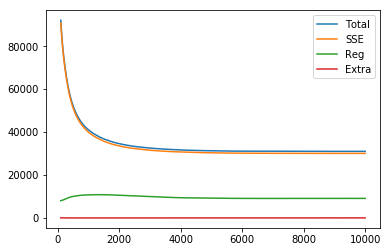

In [12]:
# evaluate result

n_skip = 100
pd.DataFrame(c_path[:, :-1], columns=['Total', 'SSE', 'Reg', 'Extra']).iloc[n_skip:,:].plot()

X_filled = pd.DataFrame(res[0], index=X.index, columns=X.columns)

_, S, _ = np.linalg.svd(X_filled)
print('Effective rank = %d'%(S > 0.01).sum())
print('Max pred = %.2f'%X_filled.values.max())
print('Min Pred = %.2f'%X_filled.values.min())

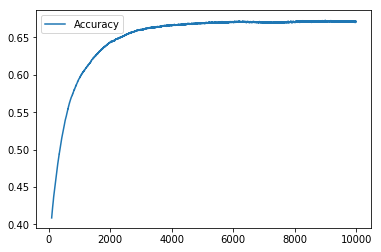

In [13]:
pd.DataFrame(c_path[:, -1], columns=['Accuracy']).iloc[n_skip:,:].plot()

In [14]:
def get_MC_prediction(user_id):
    
    rated = X.loc[pd.notnull(X[user_id]), user_id]
    df_rated = pd.DataFrame([(name_map[idx], v) for idx, v in rated.iteritems()], columns=['title', 'rating'])
    df_rated.sort_values('rating', ascending=False, inplace=True)
    
    pred = X_filled.round().loc[pd.isnull(X[user_id]), user_id]
    df_pred = pd.DataFrame([(name_map[idx], v) for idx, v in pred.iteritems()], columns=['title', 'predicted rating'])
    df_pred.sort_values('predicted rating', ascending=False, inplace=True)
    return df_pred, df_rated

In [15]:
pred, rated = get_MC_prediction(387)

In [16]:
rated.sample(20)

,title,rating
88,"Blues Brothers, The (1980)",2.0
187,James and the Giant Peach (1996),4.0
240,Cat People (1982),2.0
63,Bound (1996),5.0
231,Paths of Glory (1957),5.0
260,Kids (1995),4.0
36,"Lion King, The (1994)",2.0
178,"Blob, The (1958)",4.0
246,Casino (1995),5.0
9,Angels and Insects (1995),4.0


In [17]:
pred.sample(20)

,title,predicted rating
370,Police Story 4: Project S (Chao ji ji hua) (1993),1.0
1264,"Vie est belle, La (Life is Rosey) (1987)",1.0
2,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,4.0
762,House Arrest (1996),2.0
946,For Love or Money (1993),2.0
1281,Lashou shentan (1992),1.0
453,Barcelona (1994),4.0
447,Kicking and Screaming (1995),2.0
609,Money Talks (1997),2.0
987,Country Life (1994),1.0
